In [42]:
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from scipy.signal import argrelextrema
import itertools

In [16]:
class DiganesDataset(Dataset):
    """Diganses seals dataset."""

    def __init__(self, csv_file, root_dir, category=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            category (string, optional): Optional ilustration type, can be 'drawing' or 'photo'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        labels = pd.read_csv(csv_file)
        
        #filter only specifc type of ilusration
        if category:
            labels = labels[labels.category == category]
            labels = labels.reset_index(drop=True)
        
        self.labels_frame = labels.drop('category', axis=1)
        self.labels_name = self.labels_frame.columns[2:]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels_frame.loc[idx, "img_name"])
        image = io.imread(img_name)
        labels = np.array(self.labels_frame.iloc[idx, 2:])
 
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def show_image(self, image, labels):
        """Show image with labels"""
        img_label_names = self.labels_name[(labels > 0)].tolist()
        plt.imshow(image)
        plt.title(img_label_names)

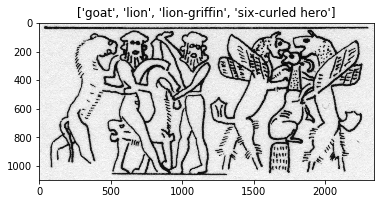

In [31]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing')

sample = diganes[0]
diganes.show_image(sample['image'], sample['labels'])

In [32]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu
from skimage import color

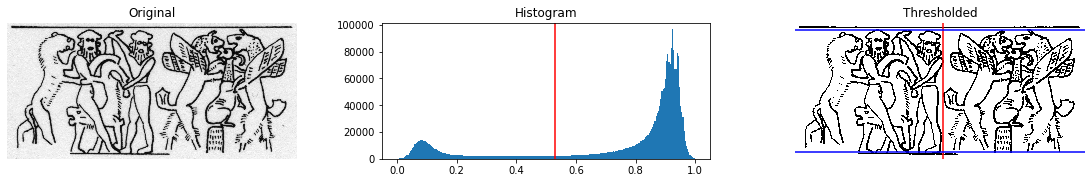

In [33]:
image = sample['image']
image = color.rgb2gray(image)
thresh = threshold_otsu(image)
binary = image > thresh
fig, axes = plt.subplots(ncols=3, figsize=(20, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')
ax[2].axvline(1198, color='r')
H = binary.shape[0]
W = binary.shape[1]
take = int(H * 0.05)
ax[2].axhline(take, color='b')
ax[2].axhline(H - take, color='b')

plt.show()

In [34]:
import sys
import scipy


In [35]:
#binary.sum(axis=0).argsort()[-500:][::-1]
pix = np.invert(binary).sum(axis=0)

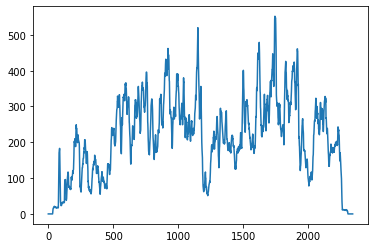

In [136]:
plt.plot(pix)
#diff = np.diff(pix)
#plt.plot(diff)
#plt.imshow(np.invert(binary))

In [38]:
def get_cuts(image, print_result=False):
    
    image = color.rgb2gray(image)
    
    #find threshold to seprate between black and white
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    #Mean of # black pixes in every column
    H = binary.shape[0]
    W = binary.shape[1]
    take = int(H * 0.5) #ignore picture up and bottom fram
    pixel_mean = np.invert(binary)[take:H-take,:].mean(axis=0)
    plt.plot(binary)

    #look for local minima
    argmin = np.argsort(pixel_mean)
    min_pts = {idx : val for val, idx in zip(pixel_mean[argmin], argmin)}
    
    cuts = set()
    for k in min_pts:
        #looking for areas which are almost empty
        if min_pts[k] > 0.05:
            break
        
        #not close to pic edges
        if k < int(W * 0.15) or k > int(W - (W * 0.15)):
            continue
        
        #local minima search
        skip = False  
        cuts_copy = cuts
        for cut in cuts:
            if (k - cut) < int(W * 0.15):
                if min_pts[k] < min_pts[cut]:
                    cuts_copy.remove(cut)
                else:
                    skip = True
                break
        
        cuts = cuts_copy
        if skip == True:
            continue
            
        cuts.add(k)
    
    if print_result:
        print_cuts(image, pixel_mean, cuts)
        
    return cuts